<a href="https://colab.research.google.com/github/SalhaAlzahrani/DiagnosticMLP/blob/main/CT_DiagnosticMLP_Kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟨 Kidney CT Image classification with modern MLP models



This notebook implements five modern attention-free, multi-layer perceptron (MLP) based models for medical image classification, demonstrated on the CT medical image datasets:

- The MLP-Mixer model, by Ilya Tolstikhin et al., based on two types of MLPs.
- The FNet model, by James Lee-Thorp et al., based on unparameterized Fourier Transform.
- The gMLP model, by Hanxiao Liu et al., based on MLP with gating.
- The resMLP model, by Touvron et al. (2023), based on residual connections.
- The DiagnosticMLP moadel, by Alzahrani S. (2024), based on three types of MLPs with gating, preceded by unparameterized Fourier Transform.


In [ ]:
!pip install nest_asyncio
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math
import nest_asyncio
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



---

## 🟡 plot_training_curves

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(len(history.history['loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('_mpl-gallery') #ggplot #bmh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=10)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10)

## 🟡 Hyperparameters


In [ ]:
path = '/content/drive/MyDrive/CT_Datasets/Computed Tomography (CT) of the Kidney/'

image_size = 64 # We'll resize input images to this size.
patch_size = 256
input_shape = (64, 64, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


## 🟡 Dataset


In [ ]:
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 12456 files belonging to 4 classes.
Using 11211 files for training.
Found 12456 files belonging to 4 classes.
Using 1245 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
##################
num_classes = len(class_names)
##################
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(num_classes): classes.append(i)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

['Cyst', 'Normal', 'Stone', 'Tumor']


{0: 0.8373218607152461,
 1: 0.6133543431160134,
 2: 2.261437908496732,
 3: 1.363994743758213}

In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## 🟡 Classification model
We implement a method that builds a classifier given the processing blocks.

In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

## 🟡 Experiment
We implement a utility function to compile, train, and evaluate a given model.

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
            keras.metrics.MeanSquaredError(name='Brier score'),
            keras.metrics.F1Score(name='F1 score'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.AUC(name='AUC'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

## 🟡 Augmentation


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
        layers.RandomContrast(factor=0.2),
        layers.RandomCrop(height=image_size, width=image_size),
        layers.RandomBrightness(factor=0.2),
    ],
    name="data_augmentation",
)

## 🟡 Patch extraction


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

# ⚛ MLP-Mixer model
The MLP-Mixer is an architecture based exclusively on multi-layer perceptrons (MLPs), that contains two types of MLP layers:

One applied independently to image patches, which mixes the per-location features.
The other applied across patches (along channels), which mixes spatial information.
This is similar to a depthwise separable convolution based model such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization instead of batch normalization.



In [ ]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

In [ ]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
mlpmixer_classifier = build_classifier(mlpmixer_blocks)

In [ ]:
history_mlpmixer = run_experiment(mlpmixer_classifier)

Epoch 1/100
351/351 [==============================] - 23s 34ms/step - loss: 7.7659 - accuracy: 0.3417 - top5-acc: 1.0000 - Brier score: 594.7429 - F1 score: 0.3149 - Recall: 0.6475 - Precision: 0.2946 - AUC: 0.5742 - val_loss: 2.5384 - val_accuracy: 0.4369 - val_top5-acc: 1.0000 - val_Brier score: 11.1949 - val_F1 score: 0.2286 - val_Recall: 0.6482 - val_Precision: 0.3273 - val_AUC: 0.6190 - lr: 0.0010
Epoch 2/100
351/351 [==============================] - 11s 30ms/step - loss: 1.6103 - accuracy: 0.4315 - top5-acc: 1.0000 - Brier score: 4.5408 - F1 score: 0.3964 - Recall: 0.5831 - Precision: 0.3575 - AUC: 0.6363 - val_loss: 1.8042 - val_accuracy: 0.4972 - val_top5-acc: 1.0000 - val_Brier score: 13.5490 - val_F1 score: 0.3318 - val_Recall: 0.7269 - val_Precision: 0.3098 - val_AUC: 0.6111 - lr: 0.0010
Epoch 3/100
351/351 [==============================] - 11s 30ms/step - loss: 1.3480 - accuracy: 0.4802 - top5-acc: 1.0000 - Brier score: 4.3995 - F1 score: 0.4407 - Recall: 0.6055 - Precis

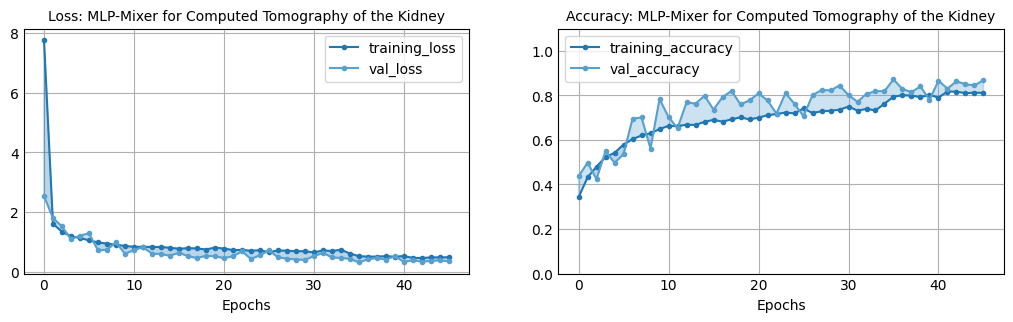

In [ ]:
plot_training_curves(history_mlpmixer, 'MLP-Mixer for Computed Tomography of the Kidney')

The MLP-Mixer model tends to have much less number of parameters compared to convolutional and transformer-based models, which leads to less training and serving computational cost.

As mentioned in the MLP-Mixer paper, when pre-trained on large datasets, or with modern regularization schemes, the MLP-Mixer attains competitive scores to state-of-the-art models. You can obtain better results by increasing the embedding dimensions, increasing, increasing the number of mixer blocks, and training the model for longer. You may also try to increase the size of the input images and use different patch sizes.


---



# ⚛ FNet model
The FNet uses a similar block to the Transformer block. However, FNet replaces the self-attention layer in the Transformer block with a parameter-free 2D Fourier transformation layer:

- One 1D Fourier Transform is applied along the patches.
- One 1D Fourier Transform is applied along the channels.

In [ ]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

In [ ]:
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)

In [ ]:
history_fnet = run_experiment(fnet_classifier)

Epoch 1/100


349/351 [============================>.] - ETA: 0s - loss: 1.3066 - accuracy: 0.4201 - top5-acc: 1.0000 - Brier score: 0.5640 - F1 score: 0.3655 - Recall: 0.2096 - Precision: 0.5394 - AUC: 0.6302

351/351 [==============================] - 16s 31ms/step - loss: 1.3064 - accuracy: 0.4204 - top5-acc: 1.0000 - Brier score: 0.5638 - F1 score: 0.3657 - Recall: 0.2100 - Precision: 0.5398 - AUC: 0.6304 - val_loss: 1.1772 - val_accuracy: 0.4241 - val_top5-acc: 1.0000 - val_Brier score: 0.5050 - val_F1 score: 0.3399 - val_Recall: 0.2835 - val_Precision: 0.5983 - val_AUC: 0.6978 - lr: 0.0010
Epoch 2/100
351/351 [==============================] - 10s 28ms/step - loss: 1.2189 - accuracy: 0.4911 - top5-acc: 1.0000 - Brier score: 0.6664 - F1 score: 0.4239 - Recall: 0.4105 - Precision: 0.5182 - AUC: 0.7016 - val_loss: 1.0830 - val_accuracy: 0.5631 - val_top5-acc: 1.0000 - val_Brier score: 0.5077 - val_F1 score: 0.5097 - val_Recall: 0.4297 - val_Precision: 0.5643 - val_AUC: 0.7595 - lr: 0.0010
Epoch 3/100
351/351 [==============================] - 10s 27ms/step - loss: 1.1538 - accuracy: 0.5286 - top5-acc: 1.0000 - Brier score: 0.8558 - F1 score: 0.4664 - Recall: 0.5086 - Precision: 0.4925 - AU

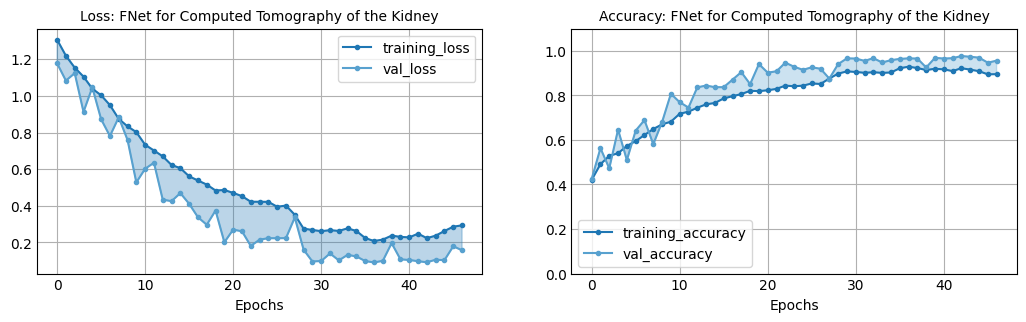

In [ ]:
plot_training_curves(history_fnet, 'FNet for Computed Tomography of the Kidney')

As shown in the FNet paper, better results can be achieved by increasing the embedding dimensions, increasing the number of FNet blocks, and training the model for longer. You may also try to increase the size of the input images and use different patch sizes. The FNet scales very efficiently to long inputs, runs much faster than attention-based Transformer models, and produces competitive accuracy results.



---



# ⚛ gMLP model
The gMLP is a MLP architecture that features a Spatial Gating Unit (SGU). The SGU enables cross-patch interactions across the spatial (channel) dimension, by:

- Transforming the input spatially by applying linear projection across patches (along channels).
- Applying element-wise multiplication of the input and its spatial transformation.


In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.channel_projection2 = layers.Dense(units=embedding_dim)
        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [ ]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
gmlp_classifier = build_classifier(gmlp_blocks)

In [ ]:
history_gmlp = run_experiment(gmlp_classifier)

Epoch 1/100
351/351 [==============================] - 16s 31ms/step - loss: 1.4009 - accuracy: 0.3373 - top5-acc: 1.0000 - Brier score: 0.4437 - F1 score: 0.3083 - Recall: 0.3063 - Precision: 0.3381 - AUC: 0.5822 - val_loss: 1.2001 - val_accuracy: 0.4803 - val_top5-acc: 1.0000 - val_Brier score: 0.8632 - val_F1 score: 0.3072 - val_Recall: 0.5904 - val_Precision: 0.4003 - val_AUC: 0.6880 - lr: 0.0010
Epoch 2/100
351/351 [==============================] - 10s 28ms/step - loss: 1.2275 - accuracy: 0.4760 - top5-acc: 1.0000 - Brier score: 0.6456 - F1 score: 0.4180 - Recall: 0.5410 - Precision: 0.4210 - AUC: 0.6958 - val_loss: 0.9001 - val_accuracy: 0.6289 - val_top5-acc: 1.0000 - val_Brier score: 0.8285 - val_F1 score: 0.5698 - val_Recall: 0.7213 - val_Precision: 0.5079 - val_AUC: 0.8186 - lr: 0.0010
Epoch 3/100
351/351 [==============================] - 10s 27ms/step - loss: 1.1241 - accuracy: 0.5245 - top5-acc: 1.0000 - Brier score: 0.9418 - F1 score: 0.4772 - Recall: 0.6022 - Precision:

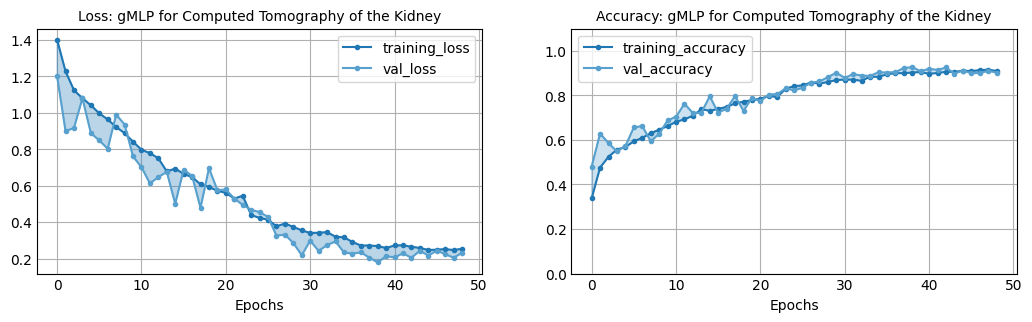

In [ ]:
plot_training_curves(history_gmlp, 'gMLP for Computed Tomography of the Kidney')

As shown in the gMLP paper, better results can be achieved by increasing the embedding dimensions, increasing the number of gMLP blocks, and training the model for longer. You may also try to increase the size of the input images and use different patch sizes. Note that, the paper used advanced regularization strategies, such as MixUp and CutMix, as well as AutoAugment.



---



# ⚛ ResMLP

In [ ]:
class Affine(tf.keras.layers.Layer):
    def __init__(self, n_channels:int, biased:bool):
        super(Affine, self).__init__()
        self.n_channels = n_channels
        self.biased = biased
        self.a = tf.Variable(tf.ones([1,1,self.n_channels]), dtype = 'float32') if self.biased else tf.Variable(tf.random.normal([1,1,self.n_channels], 0, 0.001), dtype = 'float32')
        self.b = tf.Variable(tf.zeros([1,1,self.n_channels]), dtype = 'float32') if self.biased else None

    def call(self, X):
        X = X * self.a
        if self.biased:
            X = X + self.b
        return X

class ResLayer(tf.keras.layers.Layer):
    def __init__(self, n_dims:int, n_patches:int):
        super(ResLayer, self).__init__()
        self.n_dims = n_dims
        self.n_patches = n_patches
        self.affine_pre1 = Affine(self.n_dims, True)
        self.affine_pre2 = Affine(self.n_dims, True)
        self.affine_pos1 = Affine(self.n_dims, False)
        self.affine_pos2 = Affine(self.n_dims, False)
        self.t = tf.keras.layers.Permute((2,1))
        self.linear1 = tf.keras.layers.Dense(self.n_patches, kernel_initializer = tf.keras.initializers.glorot_normal())
        self.linear2 = tf.keras.layers.Dense(self.n_dims*4, kernel_initializer = tf.keras.initializers.glorot_normal())
        self.linear3 = tf.keras.layers.Dense(self.n_dims, kernel_initializer = tf.keras.initializers.glorot_normal())

    def call(self, X):
        #Cross-patch
        y = self.affine_pre1(X)
        y = self.t(y)
        y = self.linear1(y)
        y = self.t(y)
        y = self.affine_pos1(y)
        X = X + y
        #Cross-channel
        y = self.affine_pre2(X)
        y = self.linear2(y)
        y = tf.nn.gelu(y)
        y = self.linear3(y)
        y = self.affine_pos2(y)
        y = X + y
        return y

class ResMLP(tf.keras.models.Model):
    def __init__(self, n_dims:int, image_size:int, patch_size:int, n_res_layers:int, n_labels:int, mode:str = 'softmax'):
        super(ResMLP, self).__init__()
        self.n_dims = n_dims
        self.image_size = image_size
        self.patch_size = patch_size
        if (self.image_size % self.patch_size) != 0:
            raise ValueError('size error')
        self.n_patches = int((tf.square(self.image_size) / tf.square(self.patch_size)).numpy())
        self.n_res_layers = n_res_layers
        self.n_labels = n_labels
        if mode not in ['sigmoid','softmax']:
            raise ValueError('mode must be sigmoid or softmax')
        else:
            self.mode = mode
        self.patchConv = tf.keras.layers.Conv2D(self.n_dims, (self.patch_size, self.patch_size), strides = (self.patch_size, self.patch_size))
        self.reshapeL = tf.keras.layers.Reshape((self.n_patches, self.n_dims))
        self.ResLayers = [ResLayer(self.n_dims, self.n_patches) for x in range(self.n_res_layers)]
        self.gap = tf.keras.layers.GlobalAveragePooling1D()
        self.classifier = tf.keras.layers.Dense(self.n_labels if self.n_labels > 2 else 1, activation = mode, kernel_initializer = tf.keras.initializers.glorot_normal(seed = 42))

    def call(self, X):
        X = self.patchConv(X)
        X = self.reshapeL(X)
        for reslayer in self.ResLayers:
            X = reslayer(X)
        X = self.gap(X)
        X = self.classifier(X)
        return X

In [ ]:
resmlp = ResMLP(n_dims=384, image_size=64, patch_size=16, n_res_layers=4, n_labels=num_classes, mode = 'softmax')

In [ ]:
history_resmlp = run_experiment(resmlp)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


351/351 [==============================] - 15s 29ms/step - loss: 20.4929 - accuracy: 0.6293 - top5-acc: 1.0000 - Brier score: 0.1614 - F1 score: 0.6009 - Recall: 0.6191 - Precision: 0.6375 - AUC: 0.7828 - val_loss: 0.4901 - val_accuracy: 0.8562 - val_top5-acc: 1.0000 - val_Brier score: 0.0579 - val_F1 score: 0.8472 - val_Recall: 0.8482 - val_Precision: 0.8684 - val_AUC: 0.9615 - lr: 0.0010
Epoch 2/100
351/351 [==============================] - 10s 26ms/step - loss: 0.2139 - accuracy: 0.9296 - top5-acc: 1.0000 - Brier score: 0.0268 - F1 score: 0.9153 - Recall: 0.9235 - Precision: 0.9348 - AUC: 0.9907 - val_loss: 0.2054 - val_accuracy: 0.9245 - val_top5-acc: 1.0000 - val_Brier score: 0.0280 - val_F1 score: 0.9154 - val_Recall: 0.9181 - val_Precision: 0.9293 - val_AUC: 0.9915 - lr: 0.0010
Epoch 3/100
351/351 [==============================] - 10s 27ms/step - loss: 0.5237 - accuracy: 0.8943 - top5-acc: 1.0000 - Brier score: 0.0436 - F1 score: 0.8759 - Recall: 0.8921 - Precision: 0.8985 - A

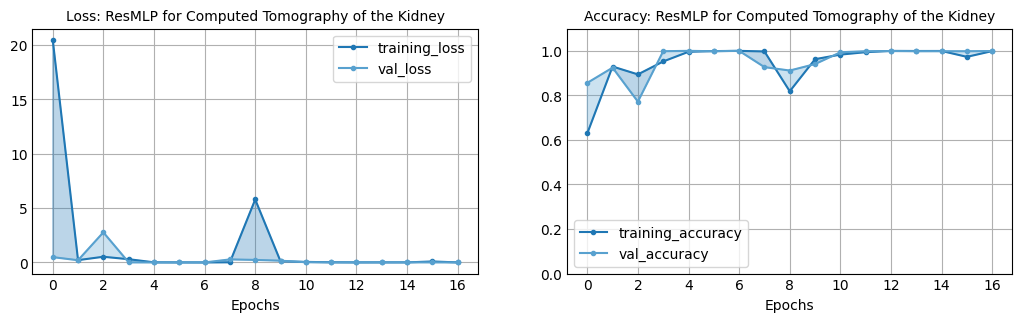

In [ ]:
plot_training_curves(history_resmlp, 'ResMLP for Computed Tomography of the Kidney')



---



# ⚛ DiagnosticMLP (proposed model)



In [ ]:
class DiagnosticMLP(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)
        self.mlp3 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.channel_projection2 = layers.Dense(units=embedding_dim)
        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        ########################################################################
        # Apply layer normalization.
        x = self.normalize(x)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        ########################################################################
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.mlp3(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        x= x + x_projected
        return x

In [ ]:
DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks)

In [ ]:
history_DiagnosticMLP = run_experiment(DiagnosticMLP_classifier)

Epoch 1/100


351/351 [==============================] - ETA: 0s - loss: 24.1937 - accuracy: 0.3321 - top5-acc: 1.0000 - Brier score: 4120.8594 - F1 score: 0.3068 - Recall: 0.6610 - Precision: 0.2784 - AUC: 0.5471

351/351 [==============================] - 25s 45ms/step - loss: 24.1937 - accuracy: 0.3321 - top5-acc: 1.0000 - Brier score: 4120.8594 - F1 score: 0.3068 - Recall: 0.6610 - Precision: 0.2784 - AUC: 0.5471 - val_loss: 7.8684 - val_accuracy: 0.3558 - val_top5-acc: 1.0000 - val_Brier score: 99.9183 - val_F1 score: 0.2785 - val_Recall: 0.5863 - val_Precision: 0.2707 - val_AUC: 0.5319 - lr: 0.0010
Epoch 2/100
351/351 [==============================] - 14s 40ms/step - loss: 6.8783 - accuracy: 0.4019 - top5-acc: 1.0000 - Brier score: 153.2350 - F1 score: 0.3704 - Recall: 0.6670 - Precision: 0.3121 - AUC: 0.5922 - val_loss: 2.7119 - val_accuracy: 0.4884 - val_top5-acc: 1.0000 - val_Brier score: 81.0907 - val_F1 score: 0.4415 - val_Recall: 0.8900 - val_Precision: 0.3217 - val_AUC: 0.6425 - lr: 0.0010
Epoch 3/100
351/351 [==============================] - 14s 40ms/step - loss: 4.3250 - accuracy: 0.4447 - top5-acc: 1.0000 - Brier score: 124.0567 - F1 score: 0.4097 - Recall: 0.6904 - Precision: 0

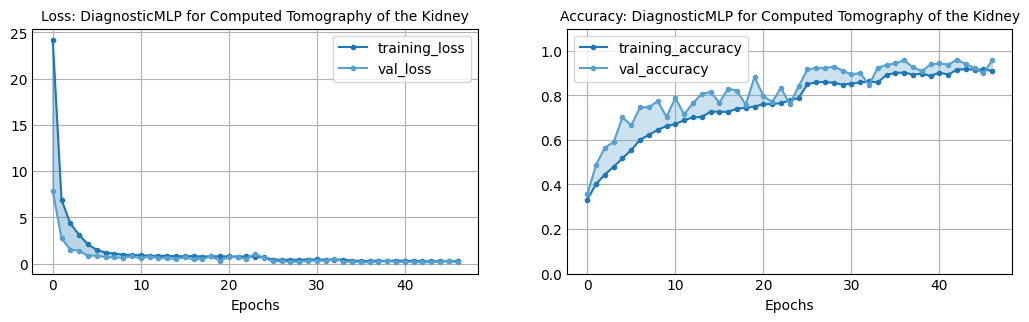

In [ ]:
plot_training_curves(history_DiagnosticMLP, 'DiagnosticMLP for Computed Tomography of the Kidney')



---



# 🟨 Comparison: CT of the Kidney

In [ ]:
def run_experiment_2(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
            keras.metrics.MeanSquaredError(name='Brier score'),
            keras.metrics.F1Score(name='F1 score'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.AUC(name='AUC'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Fit the model.
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        batch_size=batch_size,
        epochs=50,
        validation_split=0.1,
        class_weight=class_weights_dict,
        callbacks=[reduce_lr],
    )
    # Return history to plot learning curves.
    return history

In [ ]:
history_mlpmixer_ = run_experiment_2(mlpmixer_classifier)
history_fnet_ = run_experiment_2(fnet_classifier)
history_gmlp_ = run_experiment_2(gmlp_classifier)
history_resmlp_ = run_experiment_2(resmlp)
history_DiagnosticMLP_ = run_experiment_2(DiagnosticMLP_classifier)

Epoch 1/50
351/351 [==============================] - 21s 31ms/step - loss: 8.7900 - accuracy: 0.3548 - top5-acc: 1.0000 - Brier score: 377.2076 - F1 score: 0.3286 - Recall: 0.5296 - Precision: 0.3092 - AUC: 0.5750 - val_loss: 1.8435 - val_accuracy: 0.4305 - val_top5-acc: 1.0000 - val_Brier score: 12.7285 - val_F1 score: 0.3274 - val_Recall: 0.8040 - val_Precision: 0.3179 - val_AUC: 0.6299 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 10s 27ms/step - loss: 1.5872 - accuracy: 0.4494 - top5-acc: 1.0000 - Brier score: 5.9217 - F1 score: 0.4112 - Recall: 0.6316 - Precision: 0.3582 - AUC: 0.6461 - val_loss: 1.5091 - val_accuracy: 0.3984 - val_top5-acc: 1.0000 - val_Brier score: 9.1824 - val_F1 score: 0.3724 - val_Recall: 0.7687 - val_Precision: 0.3512 - val_AUC: 0.6720 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 10s 28ms/step - loss: 1.3463 - accuracy: 0.4966 - top5-acc: 1.0000 - Brier score: 5.9235 - F1 score: 0.4555 - Recall: 0.6731 - Precision:

349/351 [============================>.] - ETA: 0s - loss: 1.3194 - accuracy: 0.4041 - top5-acc: 1.0000 - Brier score: 0.4594 - F1 score: 0.3582 - Recall: 0.2760 - Precision: 0.4569 - AUC: 0.6356

351/351 [==============================] - 15s 29ms/step - loss: 1.3183 - accuracy: 0.4044 - top5-acc: 1.0000 - Brier score: 0.4596 - F1 score: 0.3585 - Recall: 0.2762 - Precision: 0.4574 - AUC: 0.6358 - val_loss: 1.2203 - val_accuracy: 0.4418 - val_top5-acc: 1.0000 - val_Brier score: 0.4853 - val_F1 score: 0.3620 - val_Recall: 0.3566 - val_Precision: 0.5224 - val_AUC: 0.6684 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 10s 27ms/step - loss: 1.2157 - accuracy: 0.4909 - top5-acc: 1.0000 - Brier score: 0.5961 - F1 score: 0.4207 - Recall: 0.4626 - Precision: 0.4851 - AUC: 0.7070 - val_loss: 1.0601 - val_accuracy: 0.5566 - val_top5-acc: 1.0000 - val_Brier score: 0.9315 - val_F1 score: 0.5066 - val_Recall: 0.6104 - val_Precision: 0.4683 - val_AUC: 0.7508 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 10s 27ms/step - loss: 1.1692 - accuracy: 0.5083 - top5-acc: 1.0000 - Brier score: 0.8402 - F1 score: 0.4426 - Recall: 0.5108 - Precision: 0.4832 - AUC:

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


351/351 [==============================] - 15s 28ms/step - loss: 21.8070 - accuracy: 0.6481 - top5-acc: 1.0000 - Brier score: 0.1525 - F1 score: 0.6160 - Recall: 0.6350 - Precision: 0.6578 - AUC: 0.7930 - val_loss: 0.4084 - val_accuracy: 0.8851 - val_top5-acc: 1.0000 - val_Brier score: 0.0458 - val_F1 score: 0.8708 - val_Recall: 0.8675 - val_Precision: 0.8993 - val_AUC: 0.9699 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 9s 26ms/step - loss: 0.4515 - accuracy: 0.8877 - top5-acc: 1.0000 - Brier score: 0.0445 - F1 score: 0.8681 - Recall: 0.8813 - Precision: 0.8948 - AUC: 0.9695 - val_loss: 1.6148 - val_accuracy: 0.7020 - val_top5-acc: 1.0000 - val_Brier score: 0.1304 - val_F1 score: 0.7140 - val_Recall: 0.7004 - val_Precision: 0.7021 - val_AUC: 0.8785 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 10s 27ms/step - loss: 0.1088 - accuracy: 0.9656 - top5-acc: 1.0000 - Brier score: 0.0134 - F1 score: 0.9575 - Recall: 0.9646 - Precision: 0.9673 - AUC:

351/351 [==============================] - ETA: 0s - loss: 23.4247 - accuracy: 0.3230 - top5-acc: 1.0000 - Brier score: 5459.3086 - F1 score: 0.2990 - Recall: 0.7977 - Precision: 0.2691 - AUC: 0.5387

351/351 [==============================] - 24s 43ms/step - loss: 23.4247 - accuracy: 0.3230 - top5-acc: 1.0000 - Brier score: 5459.3086 - F1 score: 0.2990 - Recall: 0.7977 - Precision: 0.2691 - AUC: 0.5387 - val_loss: 10.8788 - val_accuracy: 0.1631 - val_top5-acc: 1.0000 - val_Brier score: 420.6180 - val_F1 score: 0.1221 - val_Recall: 0.8610 - val_Precision: 0.2908 - val_AUC: 0.5806 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 14s 39ms/step - loss: 6.9351 - accuracy: 0.3985 - top5-acc: 1.0000 - Brier score: 257.2378 - F1 score: 0.3671 - Recall: 0.7471 - Precision: 0.2943 - AUC: 0.5772 - val_loss: 1.8202 - val_accuracy: 0.5984 - val_top5-acc: 1.0000 - val_Brier score: 143.7787 - val_F1 score: 0.4917 - val_Recall: 0.9775 - val_Precision: 0.2835 - val_AUC: 0.5872 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 14s 39ms/step - loss: 4.2552 - accuracy: 0.4455 - top5-acc: 1.0000 - Brier score: 173.8592 - F1 score: 0.4109 - Recall: 0.8361 - Precision: 

In [ ]:
def plot_comparison_curves(history_mlpmixer_, history_fnet_, history_gmlp_, history_resmlp_, history_DiagnosticMLP_):
    epochs = range(len(history_mlpmixer_.history['loss']))
    loss_1 = np.array(history_mlpmixer_.history['val_loss'])
    loss_2 = np.array(history_fnet_.history['val_loss'])
    loss_3 = np.array(history_gmlp_.history['val_loss'])
    loss_4 = np.array(history_resmlp_.history['val_loss'])
    loss_5 = np.array(history_DiagnosticMLP_.history['val_loss'])

    accuracy_1 = np.array(history_mlpmixer_.history['val_accuracy'])
    accuracy_2 = np.array(history_fnet_.history['val_accuracy'])
    accuracy_3 = np.array(history_gmlp_.history['val_accuracy'])
    accuracy_4 = np.array(history_resmlp_.history['val_accuracy'])
    accuracy_5 = np.array(history_DiagnosticMLP_.history['val_accuracy'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    #plt.style.use('ggplot')
    plt.style.use('seaborn-whitegrid')

    # Plot loss
    ax1.plot(epochs, loss_1, label='MLP-Mixer', marker='.', )
    ax1.plot(epochs, loss_2, label='FNet', marker='.', )
    ax1.plot(epochs, loss_3, label='gMLP', marker='.', )
    ax1.plot(epochs, loss_4, label='ResMLP', marker='.', )
    ax1.plot(epochs, loss_5, label='DiagnosticMLP', marker='.', )

    ax1.set_title('Loss Comparison - CT of the Kidney', fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=10, borderaxespad=1, frameon=True)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy_1, label='MLP-Mixer', marker='.')
    ax2.plot(epochs, accuracy_2, label='FNet', marker='.')
    ax2.plot(epochs, accuracy_3, label='gMLP', marker='.')
    ax2.plot(epochs, accuracy_4, label='ResMLP', marker='.')
    ax2.plot(epochs, accuracy_5, label='DiagnosticMLP', marker='.')

    ax2.set_title('Accuracy Comparison - CT of the Kidney', fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10, borderaxespad=1, frameon=True)

<ipython-input-36-c01b078dd88a>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


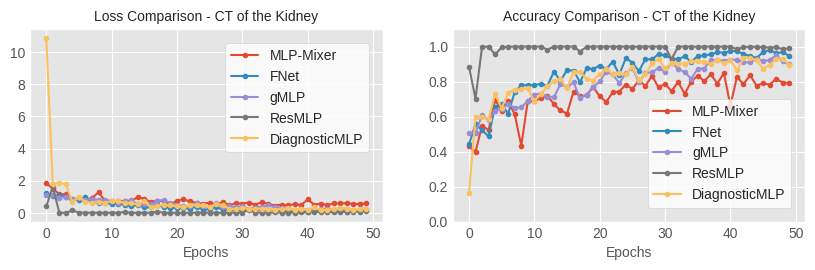

In [ ]:
plot_comparison_curves(history_mlpmixer_, history_fnet_, history_gmlp_, history_resmlp_, history_DiagnosticMLP_)

In [ ]:
history_mlpmixer_ = run_experiment_2(mlpmixer_classifier)
history_fnet_ = run_experiment_2(fnet_classifier)
history_gmlp_ = run_experiment_2(gmlp_classifier)
history_resmlp_ = run_experiment_2(resmlp)
history_DiagnosticMLP_ = run_experiment_2(DiagnosticMLP_classifier)

Epoch 1/50
351/351 [==============================] - 22s 33ms/step - loss: 8.3459 - accuracy: 0.3417 - top5-acc: 1.0000 - Brier score: 383.6691 - F1 score: 0.3152 - Recall: 0.5638 - Precision: 0.3064 - AUC: 0.5747 - val_loss: 1.9038 - val_accuracy: 0.3277 - val_top5-acc: 1.0000 - val_Brier score: 7.0237 - val_F1 score: 0.3021 - val_Recall: 0.6715 - val_Precision: 0.3145 - val_AUC: 0.6080 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 11s 30ms/step - loss: 1.4980 - accuracy: 0.4560 - top5-acc: 1.0000 - Brier score: 5.5832 - F1 score: 0.4170 - Recall: 0.6316 - Precision: 0.3574 - AUC: 0.6447 - val_loss: 1.1720 - val_accuracy: 0.5478 - val_top5-acc: 1.0000 - val_Brier score: 6.5843 - val_F1 score: 0.4520 - val_Recall: 0.8378 - val_Precision: 0.3493 - val_AUC: 0.6862 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 10s 29ms/step - loss: 1.3116 - accuracy: 0.4992 - top5-acc: 1.0000 - Brier score: 5.2016 - F1 score: 0.4562 - Recall: 0.5959 - Precision: 

351/351 [==============================] - ETA: 0s - loss: 1.3176 - accuracy: 0.4071 - top5-acc: 1.0000 - Brier score: 0.4254 - F1 score: 0.3572 - Recall: 0.3706 - Precision: 0.4086 - AUC: 0.6437

351/351 [==============================] - 16s 30ms/step - loss: 1.3176 - accuracy: 0.4071 - top5-acc: 1.0000 - Brier score: 0.4254 - F1 score: 0.3572 - Recall: 0.3706 - Precision: 0.4086 - AUC: 0.6437 - val_loss: 1.2117 - val_accuracy: 0.4819 - val_top5-acc: 1.0000 - val_Brier score: 0.3023 - val_F1 score: 0.3883 - val_Recall: 0.3502 - val_Precision: 0.5070 - val_AUC: 0.6966 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 10s 28ms/step - loss: 1.2122 - accuracy: 0.4945 - top5-acc: 1.0000 - Brier score: 0.6008 - F1 score: 0.4246 - Recall: 0.4415 - Precision: 0.4903 - AUC: 0.7066 - val_loss: 1.1157 - val_accuracy: 0.5116 - val_top5-acc: 1.0000 - val_Brier score: 0.7256 - val_F1 score: 0.4803 - val_Recall: 0.5253 - val_Precision: 0.4823 - val_AUC: 0.7381 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 10s 27ms/step - loss: 1.1574 - accuracy: 0.5160 - top5-acc: 1.0000 - Brier score: 0.8569 - F1 score: 0.4557 - Recall: 0.5067 - Precision: 0.4943 - AUC:

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


351/351 [==============================] - 15s 28ms/step - loss: 26.6406 - accuracy: 0.6179 - top5-acc: 1.0000 - Brier score: 0.1691 - F1 score: 0.5840 - Recall: 0.6033 - Precision: 0.6282 - AUC: 0.7585 - val_loss: 0.2343 - val_accuracy: 0.9269 - val_top5-acc: 1.0000 - val_Brier score: 0.0292 - val_F1 score: 0.9204 - val_Recall: 0.9100 - val_Precision: 0.9434 - val_AUC: 0.9915 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 10s 27ms/step - loss: 0.3970 - accuracy: 0.8848 - top5-acc: 1.0000 - Brier score: 0.0449 - F1 score: 0.8631 - Recall: 0.8750 - Precision: 0.8956 - AUC: 0.9743 - val_loss: 0.3009 - val_accuracy: 0.9004 - val_top5-acc: 1.0000 - val_Brier score: 0.0387 - val_F1 score: 0.8846 - val_Recall: 0.8964 - val_Precision: 0.9058 - val_AUC: 0.9829 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 10s 26ms/step - loss: 0.1244 - accuracy: 0.9574 - top5-acc: 1.0000 - Brier score: 0.0163 - F1 score: 0.9500 - Recall: 0.9545 - Precision: 0.9613 - AUC

350/351 [============================>.] - ETA: 0s - loss: 25.3570 - accuracy: 0.3284 - top5-acc: 1.0000 - Brier score: 5306.0361 - F1 score: 0.3058 - Recall: 0.5062 - Precision: 0.2883 - AUC: 0.5453

351/351 [==============================] - 25s 44ms/step - loss: 25.3358 - accuracy: 0.3286 - top5-acc: 1.0000 - Brier score: 5300.9238 - F1 score: 0.3059 - Recall: 0.5064 - Precision: 0.2884 - AUC: 0.5454 - val_loss: 3.0347 - val_accuracy: 0.5984 - val_top5-acc: 1.0000 - val_Brier score: 62.4242 - val_F1 score: 0.4554 - val_Recall: 0.8048 - val_Precision: 0.3722 - val_AUC: 0.6841 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 14s 40ms/step - loss: 6.7274 - accuracy: 0.4040 - top5-acc: 1.0000 - Brier score: 165.8429 - F1 score: 0.3726 - Recall: 0.6443 - Precision: 0.3224 - AUC: 0.6004 - val_loss: 4.0112 - val_accuracy: 0.3727 - val_top5-acc: 1.0000 - val_Brier score: 60.9089 - val_F1 score: 0.3660 - val_Recall: 0.7566 - val_Precision: 0.3309 - val_AUC: 0.6300 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 14s 40ms/step - loss: 4.8266 - accuracy: 0.4443 - top5-acc: 1.0000 - Brier score: 115.0048 - F1 score: 0.4116 - Recall: 0.6499 - Precision: 0.3

<ipython-input-26-c01b078dd88a>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


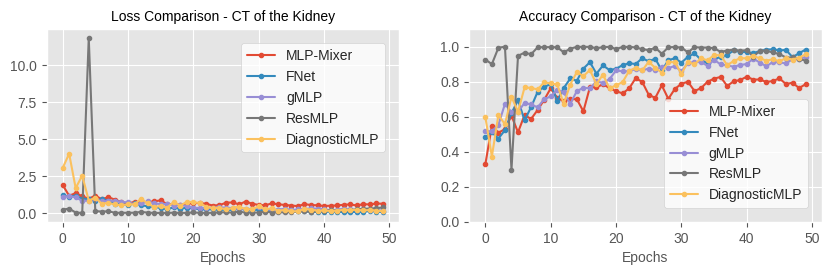

In [ ]:
plot_comparison_curves(history_mlpmixer_, history_fnet_, history_gmlp_, history_resmlp_, history_DiagnosticMLP_)